In [2]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def show_images(images, cmap="viridis"):
    column = 3
    row = int(math.ceil(len(images)/column))
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(row,column,i+1)
        if cmap != "gray":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')

range(1, 8)


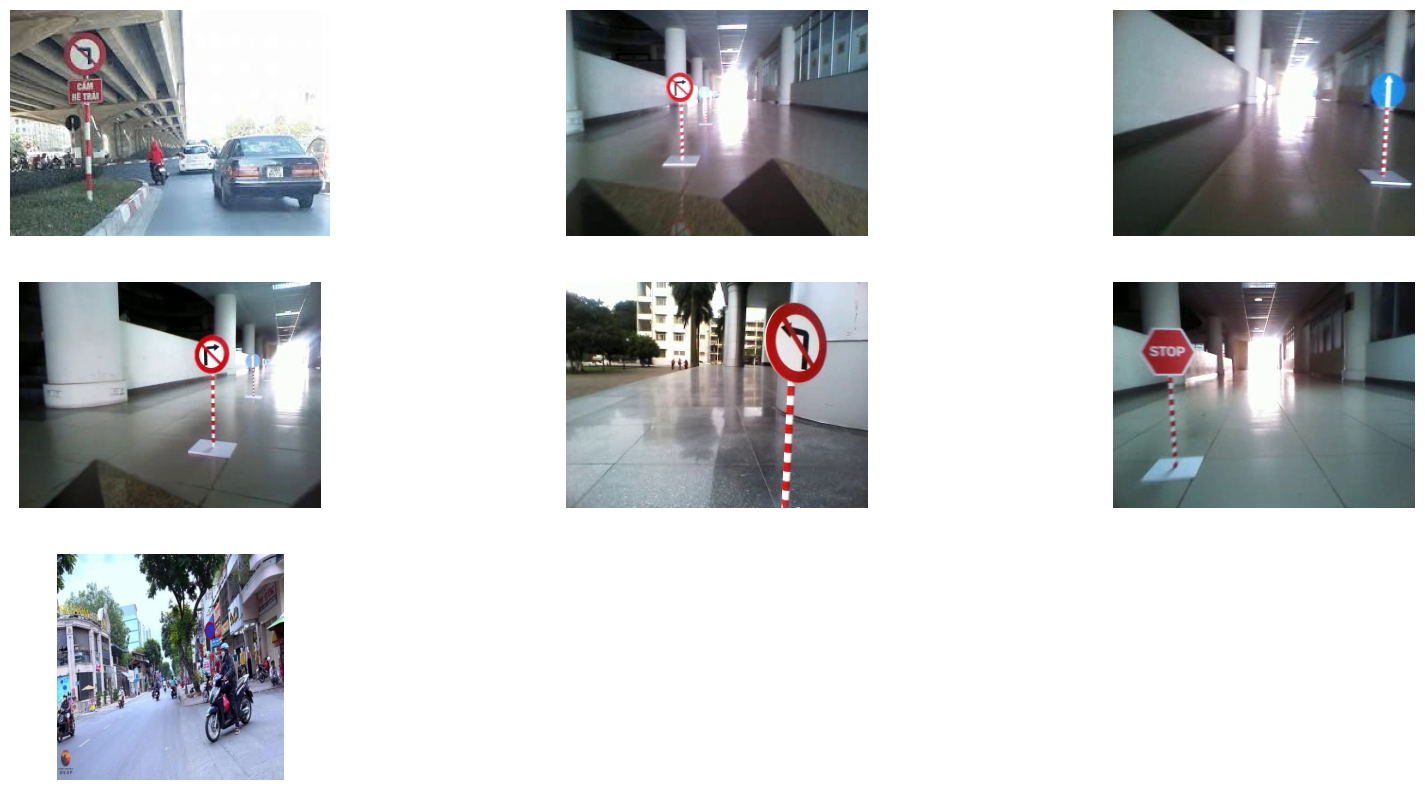

In [4]:
# Đọc hình ảnh
image_names = range(1,8)
print(image_names)
bgr_images = [cv2.imread(str(name) + ".jpg") for name in image_names]
show_images(bgr_images)

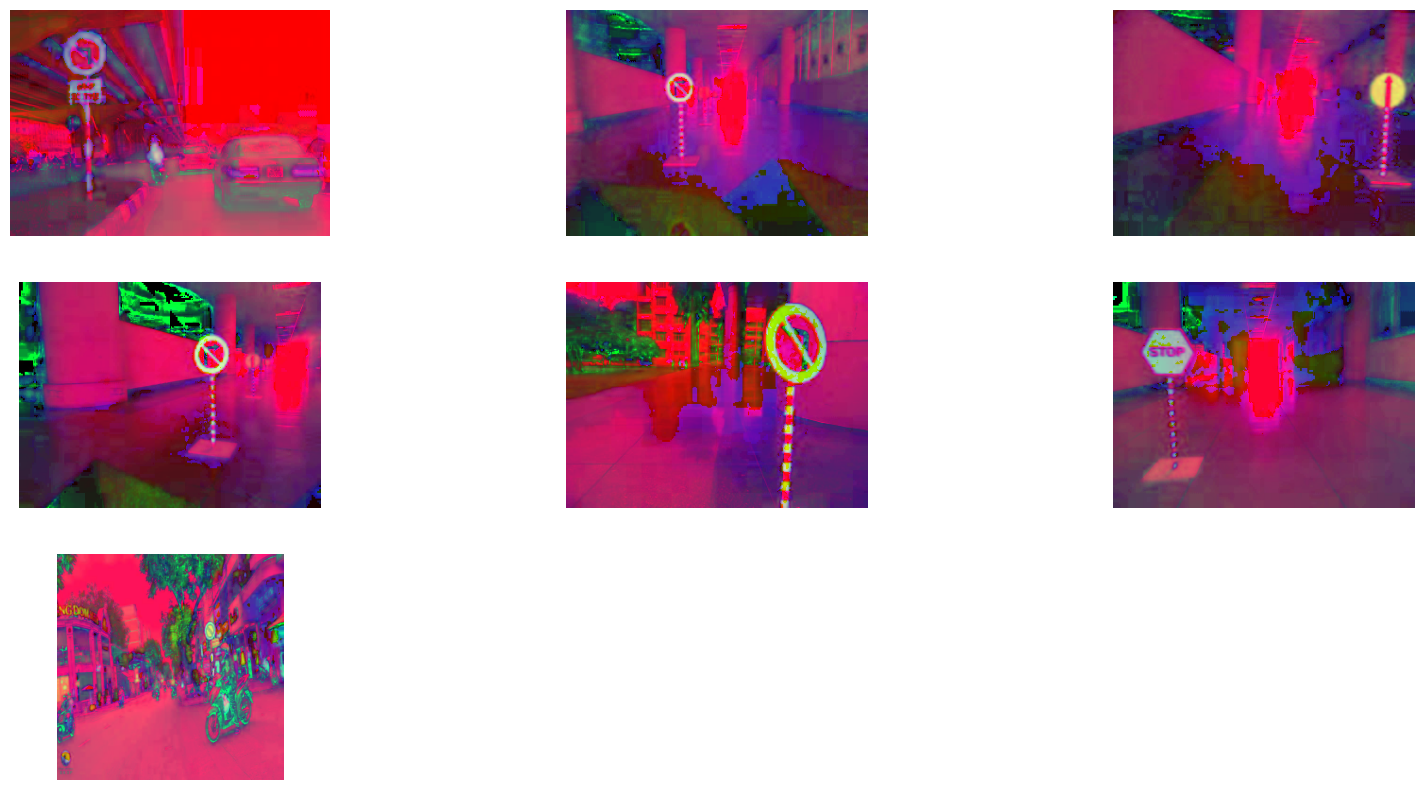

In [5]:
# mảng hsv sẽ lưu các ảnh đã được chuyển đổi sang hệ màu hsv
# sử dụng hàm cv2.cvtColor để convert ảnh từ dạng BGR sang HSV
hsvs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in bgr_images]
show_images(hsvs)

In [19]:
lower1, upper1 = np.array([0,70,50]), np.array([10,255,255])
lower2, upper2 = np.array([170,70,50]), np.array([180,255,255])

In [20]:
lower3, upper3 = np.array([85,50,200]), np.array([135,250,250])

In [6]:
def filter_signs_by_color(image):
    """Lọc các đối tượng màu đỏ và màu xanh dương - Có thể là biển báo.
        Ảnh đầu vào là ảnh màu BGR
    """
    # Chuyển ảnh sang hệ màu HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Lọc màu đỏ cho stop và biển báo cấm
    lower1, upper1 = np.array([0, 70, 50]), np.array([10, 255, 255])
    lower2, upper2 = np.array([170, 70, 50]), np.array([180, 255, 255])
    mask_1 = cv2.inRange(image, lower1, upper1) # dải màu đỏ thứ nhất
    mask_2 = cv2.inRange(image, lower2, upper2) # dải màu đỏ thứ hai
    mask_r = cv2.bitwise_or(mask_1, mask_2) # kết hợp 2 kết quả từ 2 dải màu khác nhau

    # Lọc màu xanh cho biển báo điều hướng
    #lower3, upper3 = np.array([85, 130, 90]), np.array([150, 255, 250])
    #lower3, upper3 = np.array([85, 50, 200]), np.array([135, 250, 250])
    # lower3, upper3 = np.array([85, 93, 112]), np.array([150, 255, 255])
    lower3, upper3 = np.array([85, 130, 90]), np.array([150, 255, 255]) #roundabout
    mask_b = cv2.inRange(image, lower3,upper3)

    # Kết hợp các kết quả
    mask_final  = cv2.bitwise_or(mask_r,mask_b)
    return mask_final

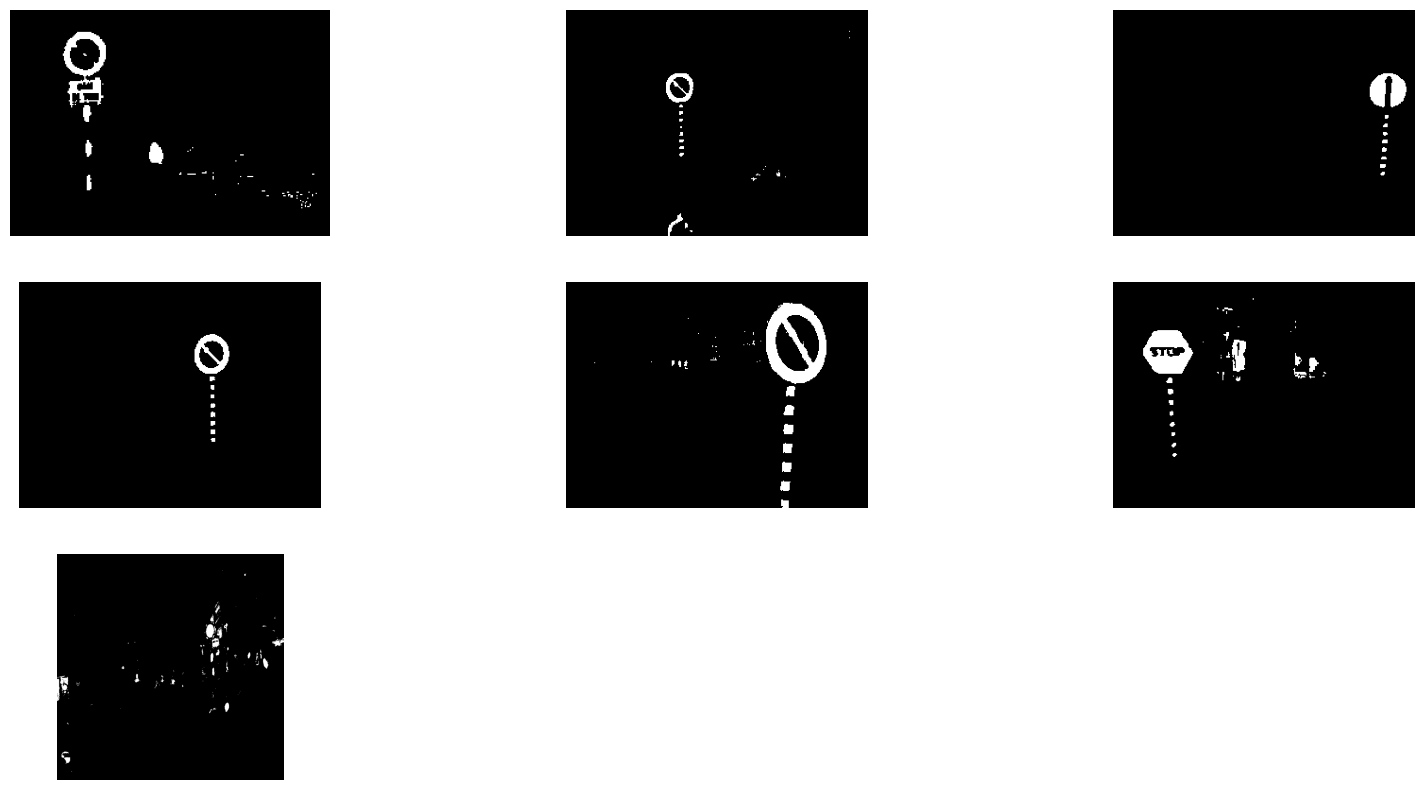

In [7]:
masks = [filter_signs_by_color(img) for img in bgr_images]
show_images(masks)

In [8]:
def get_boxes_from_mask(mask):
    """Tìm kiếm hộp bao biển báo
    """
    bboxes = []

    nccomps = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    numLabels, labels, stats, centroids = nccomps
    im_height, im_width = mask.shape[:2]
    for i in range(numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        # Lọc các vật quá nhỏ, có thể là nhiễu
        if w < 20 or h < 20:
            continue
        # Lọc các vật quá lớn
        if w > 0.8 * im_width or h > 0.8 * im_height:
            continue
        # Loại bỏ các vật có tỷ lệ dài / rộng quá khác biệt
        if w / h > 2.0 or h / w > 2.0:
            continue
        bboxes.append([x, y, w, h])
    return bboxes

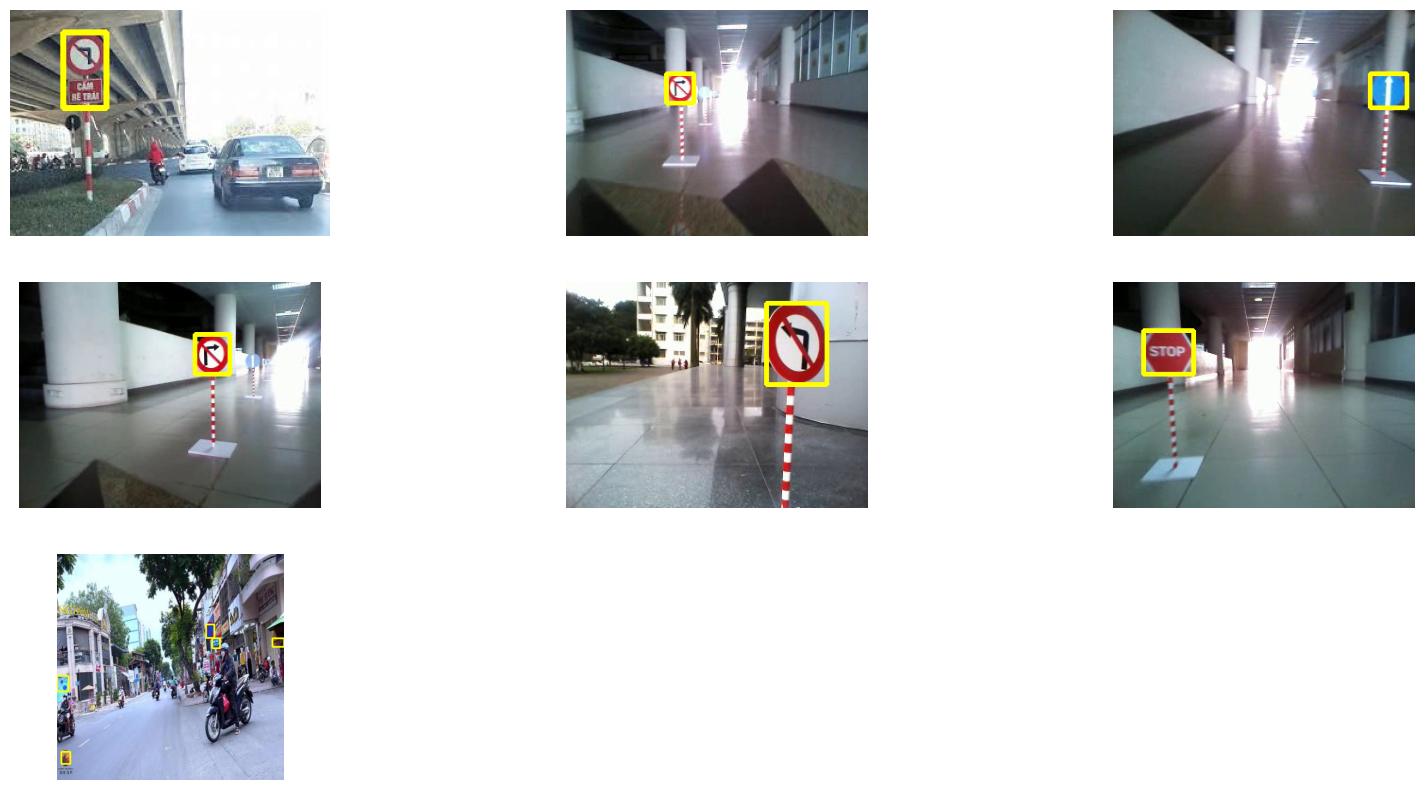

In [9]:
results = []
for i, img in enumerate(bgr_images):
    mask = filter_signs_by_color(img) # lọc theo màu sắc
    bboxes = get_boxes_from_mask(mask) # tìm kiếm khung bao của các vật từ mặt nạ màu sắc
    draw = img.copy() # Sao chép ảnh màu tương ứng để vẽ lên
    for bbox in bboxes:
        x, y, w, h = bbox
        # Vẽ khối hộp bao quanh biển báo
        cv2.rectangle(draw, (x,y), (x+w,y+h), (0,255,255), 3) # vẽ hình chữ nhật bao quanh vật
    results.append(draw)
show_images(results)

In [13]:
# Nạp mô hình bằng OpenCV
# model = cv2.dnn.readNetFromONNX("traffic_sign_classifier_lenet_v2.onnx")

# # Hàm phát hiện biển báo
# def detect_traffic_signs(img, model, draw=None):
#     """Phát hiện biển báo
#     """

#     # Các lớp biển báo
#     classes = ['unknown', 'left', 'no_left', 'right',
#                'no_right', 'straight', 'stop']

#     # Phát hiện biển báo theo màu sắc
#     mask = filter_signs_by_color(img)
#     bboxes = get_boxes_from_mask(mask)

#     # Tiền xử lý
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32)
#     img = img / 255.0

#     # Phân loại biển báo dùng CNN
#     signs = []
#     for bbox in bboxes:
#         # Cắt vùng cần phân loại
#         x, y, w, h = bbox
#         sub_image = img[y:y+h, x:x+w]

#         if sub_image.shape[0] < 20 or sub_image.shape[1] < 20:
#             continue

#         # Tiền xử lý
#         sub_image = cv2.resize(sub_image, (32, 32))
#         sub_image = np.expand_dims(sub_image, axis=0)

#         # Sử dụng CNN để phân loại biển báo
#         model.setInput(sub_image)
#         preds = model.forward()
#         preds = preds[0]
#         cls = preds.argmax()
#         score = preds[cls]

#         # Loại bỏ các vật không phải biển báo - thuộc lớp unknown
#         if cls == 0:
#             continue

#         # Loại bỏ các vật có độ tin cậy thấp
#         if score < 0.9:
#             continue

#         signs.append([classes[cls], x, y, w, h])

#         # Vẽ các kết quả
#         if draw is not None:
#             text = classes[cls] + ' ' + str(round(score, 2))
#             cv2.rectangle(draw, (x, y), (x+w, y+h), (0, 255, 255), 4)
#             cv2.putText(draw, text, (x, y-5),
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

#     return signs
# results = []
# for i, img in enumerate(bgr_images):
#     draw = img.copy()
#     signs = detect_traffic_signs(img, model, draw=draw)
#     results.append(draw)
# show_images(results)

# Nạp mô hình bằng OpenCV
from keras.models import load_model
model = load_model('my_model9.h5')

# Hàm phát hiện biển báo
def detect_traffic_signs(img, model, draw=None):
    """Phát hiện biển báo
    """

    # Các lớp biển báo
    classes = { 1:'Speed limit (20km/h)',
            2:'Speed limit (30km/h)', 
            3:'Speed limit (50km/h)', 
            4:'Speed limit (60km/h)', 
            5:'Speed limit (70km/h)', 
            6:'Speed limit (80km/h)', 
            7:'End of speed limit (80km/h)', 
            8:'Speed limit (100km/h)', 
            9:'Speed limit (120km/h)', 
            10:'No passing', 
            11:'No passing veh over 3.5 tons', 
            12:'Right-of-way at intersection', 
            13:'Priority road', 
            14:'Yield', 
            15:'Stop', 
            16:'No vehicles', 
            17:'Veh > 3.5 tons prohibited', 
            18:'No entry', 
            19:'General caution', 
            20:'Dangerous curve left', 
            21:'Dangerous curve right', 
            22:'Double curve', 
            23:'Bumpy road', 
            24:'Slippery road', 
            25:'Road narrows on the right', 
            26:'Road work', 
            27:'Traffic signals', 
            28:'Pedestrians', 
            29:'Children crossing', 
            30:'Bicycles crossing', 
            31:'Beware of ice/snow',
            32:'Wild animals crossing', 
            33:'End speed + passing limits', 
            34:'Turn right ahead', 
            35:'Turn left ahead', 
            36:'Ahead only', 
            37:'Go straight or right', 
            38:'Go straight or left', 
            39:'Keep right', 
            40:'Keep left', 
            41:'Roundabout mandatory', 
            42:'End of no passing', 
            43:'End no passing veh > 3.5 tons' }

    # Phát hiện biển báo theo màu sắc
    mask = filter_signs_by_color(img)
    bboxes = get_boxes_from_mask(mask)

    # Tiền xử lý
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img / 255.0

    # Phân loại biển báo dùng CNN
    signs = []
    for bbox in bboxes:
        # Cắt vùng cần phân loại
        x, y, w, h = bbox
        sub_image = img[y:y+h, x:x+w]

        if sub_image.shape[0] < 20 or sub_image.shape[1] < 20:
            continue

        # Tiền xử lý
        sub_image = cv2.resize(sub_image, (30, 30))
        sub_image = np.expand_dims(sub_image, axis=0)

        # Sử dụng CNN để phân loại biển báo
        sub_image = np.array(sub_image)
        pred = np.argmax(model.predict(sub_image)[0], axis=-1)
        sign = classes[pred +1]
        # Loại bỏ các vật không phải biển báo - thuộc lớp unknown
   

        signs.append([sign, x, y, w, h])

        # Vẽ các kết quả
        if draw is not None:
            text = sign 
            cv2.rectangle(draw, (x, y), (x+w, y+h), (0, 255, 255), 4)
            cv2.putText(draw, text, (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    return signs
results = []
for i, img in enumerate(bgr_images):
    draw = img.copy()
    signs = detect_traffic_signs(img, model, draw=draw)
    results.append(draw)
show_images(results)


RuntimeError: Dependency error!!! PyTorch and TorchVision are not installed. Please see installation instructions in the documentation https://imageai.readthedocs.io/